In [1]:
%%HTML
<style type="text/css">

div.h2 {
    background-color: steelblue; 
    color: white; 
    padding: 8px; 
    padding-right: 300px; 
    font-size: 20px; 
    max-width: 1500px; 
    margin: auto; 
    margin-top: 50px;
}
div.h3 {
    color: steelblue; 
    font-size: 14px; 
    margin-top: 20px; 
    margin-bottom:4px;
}
div.h4 {
    font-size: 15px; 
    margin-top: 20px; 
    margin-bottom: 8px;
}
span.note {
    font-size: 5; 
    color: gray; 
    font-style: italic;
}
span.captiona {
    font-size: 5; 
    color: dimgray; 
    font-style: italic;
    margin-left: 130px;
    vertical-align: top;
}
hr {
    display: block; 
    color: gray
    height: 1px; 
    border: 0; 
    border-top: 1px solid;
}
hr.light {
    display: block; 
    color: lightgray
    height: 1px; 
    border: 0; 
    border-top: 1px solid;
}
table.dataframe th 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
}
table.dataframe td 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 14px;
    text-align: center;
} 
table.rules th 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 14px;
}
table.rules td 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 13px;
    text-align: center;
} 
table.rules tr.best
{
    color: green;
}

</style>

# Predicting News Category with DistilBERT
<p style="margin-top:40px"> 
Sections:  </p>

  - <a href='#bg'>Introduction</a>
  - <a href='#il'>Import Modules and Load Data</a>
  - <a href='#eda'>Exploratory Data Analysis</a>
  - <a href='#cc'>Category Classification</a>
  - <a href='#re'>Results</a>
  - <a href='#end'>Conclusion</a>

![](https://cinedapt.com/wp-content/uploads/2019/11/huffpost-logo.png)

<a id='bg'></a>
<div class="h2">Introduction</div>
<br>
[HuffPost](https://www.huffpost.com/) is an american website about opinions and news like politcs, culture, wellness, etc. It was founded in 2005 by Andrew Breitbart, Arianna Huffington, Kenneth Lerer, and Jonah Peretti. The dataset provides data from 2012 to 2018.<br>
<br>
In this work is made a exploratory data analysis (EDA) and category classification of the news posted in HuffPost using the Headlines and Short Descriptions of these news.<br>
For the EDA, Headlines, Short Descriptions and Categories are analysed through the years, and for the classification task, it's used a lighter version of the popular Natural Language Processing (NLP) framework [BERT](https://arxiv.org/abs/1810.04805) developed by Google, called [DistilBERT](https://medium.com/huggingface/distilbert-8cf3380435b5), in this developed by huggingface.<br>
<br>
The code is hidden for a better notebook readbility. Anytime it's possible to click on the code button to see the script content.

<a id='il'></a>
<div class="h2">  Import Modules and Load Data</div>
<br>
For the task, the data is organized in DataFrames for the EDA and on Tensors for the classification. All the plots are made with Pandas, Matplotlib or Seaborn.<br>
[PyTorch](https://pytorch.org/), [Catalyst](https://github.com/catalyst-team/catalyst) and [NVIDIA Apex](https://github.com/NVIDIA/apex) are used on the classification task using Deep Learning, the pre-trained DistilBERT model. <br>
<br>
PyTorch has been my weapon of choice when working with Deep Learning, Catalyst is a wonderful PyTorch tool to make the train more clean and with a focus on reproducibility and Apex allow to use Floating Point 16 (FP16) to speed up the train, using [Mixed-precision training](https://devblogs.nvidia.com/mixed-precision-training-deep-neural-networks/).

In [2]:
# Core
import pandas as pd
import numpy as np
# Data Visualization
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
# PyTorch 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Transformers 
from transformers import AutoConfig, AutoModel, AutoTokenizer
# Catalyst
from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback, F1ScoreCallback, OptimizerCallback
from catalyst.dl.callbacks import CheckpointCallback, InferCallback
from catalyst.utils import set_global_seed, prepare_cudnn
# Extras
import warnings
warnings.filterwarnings('ignore')
import os
import logging
from typing import Mapping, List
import datetime as dt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from IPython.display import HTML, Image
# Better Reports
pd.set_option("display.max_columns", 100)
th_props = [('font-size', '13px'), ('background-color', 'white'), 
            ('color', '#666666')]
td_props = [('font-size', '15px'), ('background-color', 'white')]
styles = [dict(selector="td", props=td_props), dict(selector="th", 
            props=th_props)]
# Plots visualization improvement
%config InlineBackend.figure_format = 'retina'

In [3]:
# It's a good practice to save on a plain text the modules and its versions
# It's help others when running your experiments
!pip freeze > requirements.txt

In [4]:
data_path = "/kaggle/input/news-category-dataset/"
data = pd.read_json(data_path+"News_Category_Dataset_v2.json", lines=True)

<a id='eda'></a>
<div class="h2">  Exploratory Data Analysis</div>
<br>
A good way to start an EDA is showing the General Information about the available data. It's summarized on the Table 1.

In [5]:
# General Info
display(HTML('<span style="font-weight:bold">' + 'Table 1 - General Dataset Information'\
             + '</span>'),data.head(3)) 
print(f"Number of Samples: {data.shape[0]}")
print(f"Number of Features: {data.shape[1]}")
# Missing Values
aux = data.isnull().sum()/data.shape[0] * 100.00
if sum(aux) == 0:
    print("No Missing Data!")
else:
    aux = aux[aux > 0]
    aux = pd.DataFrame({'Feature': aux.index,
                    'Percent_Missing': aux.values})
    aux.sort_values('Percent_Missing', inplace=True)
    display(aux)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26


Number of Samples: 200853
Number of Features: 6
No Missing Data!


And the dataset has a good amount of data, about 200000 samples. The feature to be predict is `category`.<br>
All EDA uses `category`, `headline`, `short_description` and `date` features.<br>
There's no missing data on this dataset and it's very good for unstructured data.<br>
A check on Category Distributuon as shown on the Figure 1.

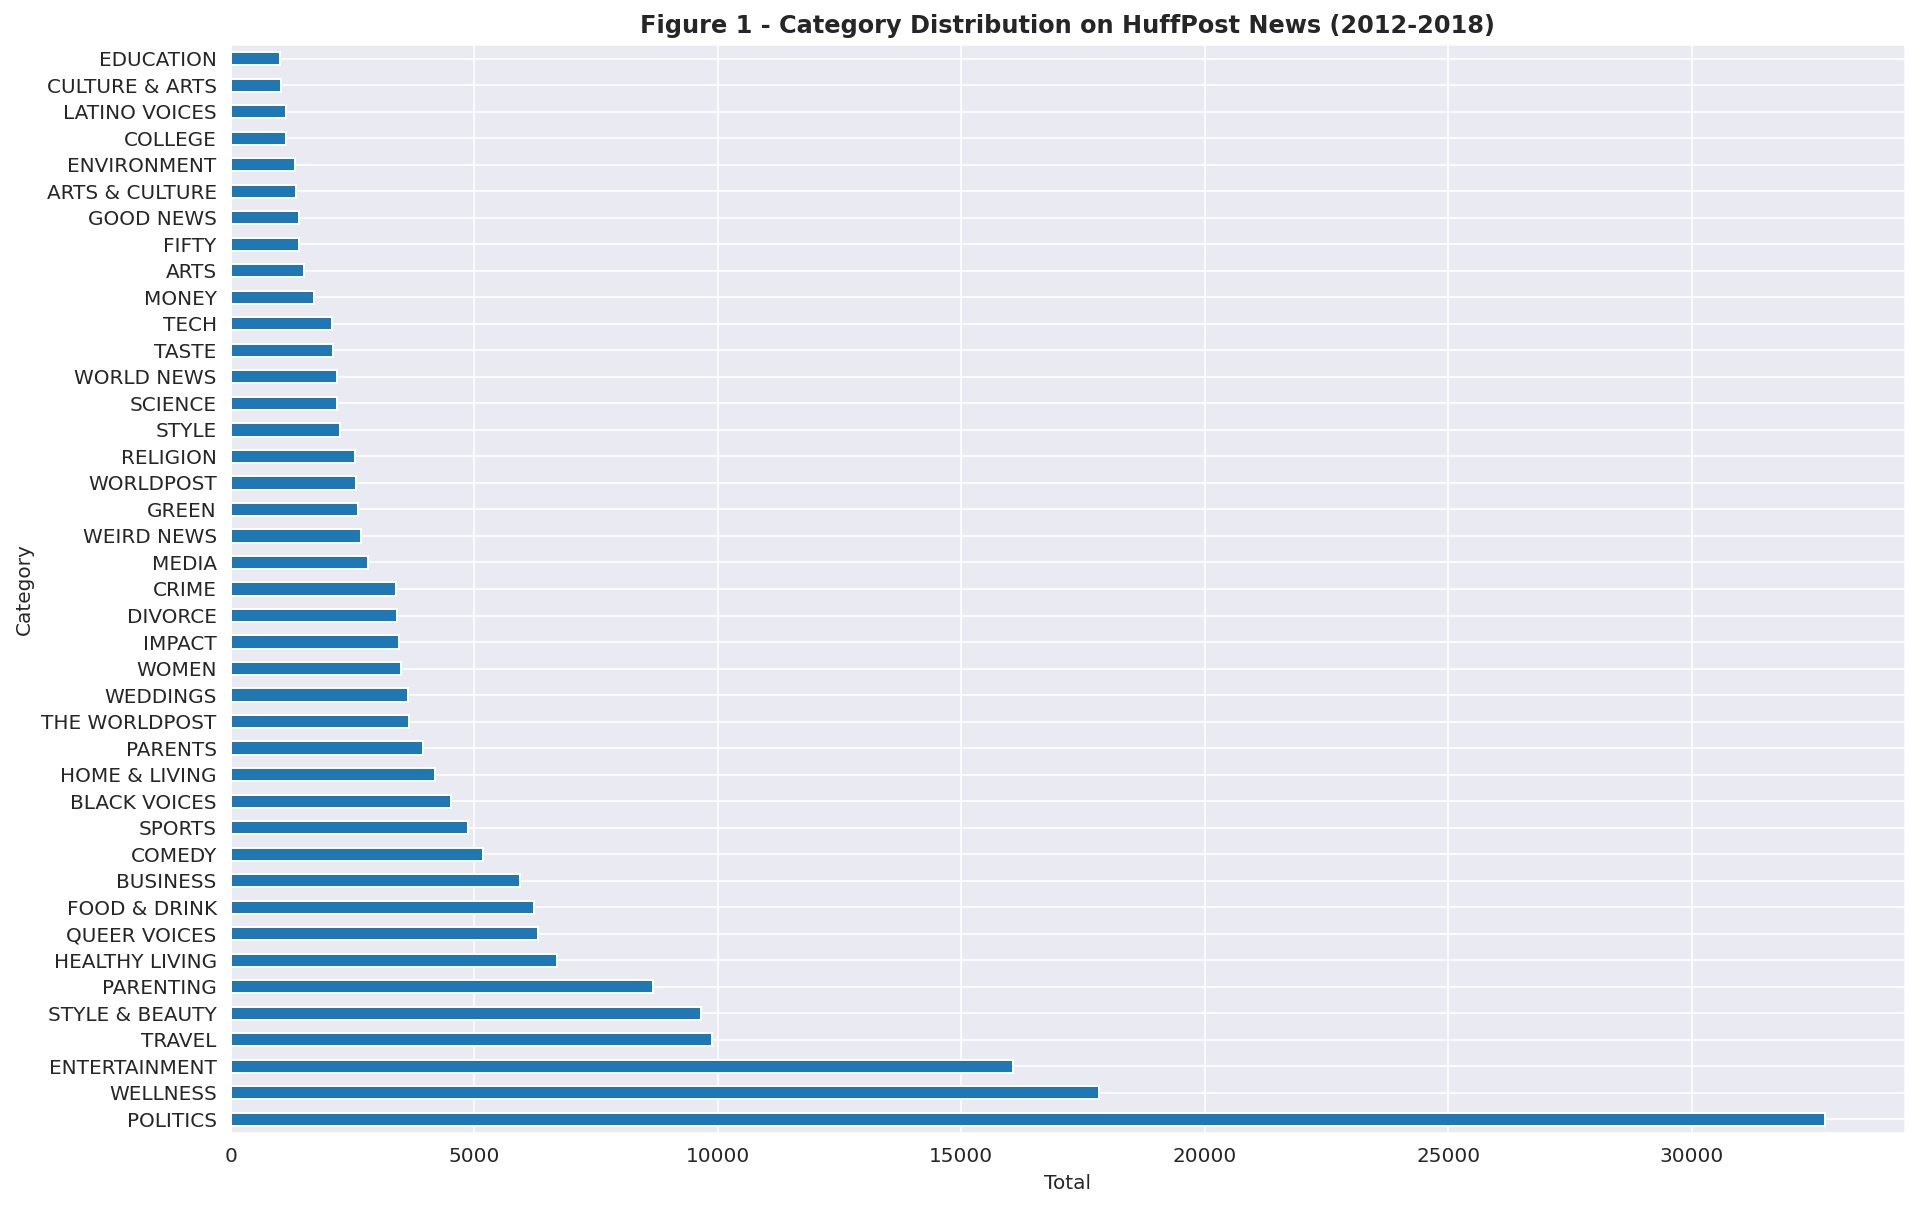

In [6]:
data['category'].value_counts().plot(kind='barh', figsize=(15,10))
plt.xlabel("Total")
plt.ylabel("Category")
plt.title("Figure 1 - Category Distribution on HuffPost News (2012-2018)",
          fontweight="bold", size=12);

Some categories are just the same with different names, like `WORLDPOST` and `THE WORLDPOSt`, to fix it and remove some imbalance from the data (`POLITCS` is present in a lot of samples), the similar categories are merged and the new distribution is shown on the Figure 2.

In [7]:
data['category']=data['category'].replace({"HEALTHY LIVING": "WELLNESS",
"QUEER VOICES": "GROUPS VOICES",
"BUSINESS": "BUSINESS & FINANCES",
"PARENTS": "PARENTING",
"BLACK VOICES": "GROUPS VOICES",
"THE WORLDPOST": "WORLD NEWS",
"STYLE": "STYLE & BEAUTY",
"GREEN": "ENVIRONMENT",
"TASTE": "FOOD & DRINK",
"WORLDPOST": "WORLD NEWS",
"SCIENCE": "SCIENCE & TECH",
"TECH": "SCIENCE & TECH",
"MONEY": "BUSINESS & FINANCES",
"ARTS": "ARTS & CULTURE",
"COLLEGE": "EDUCATION",
"LATINO VOICES": "GROUPS VOICES",
"CULTURE & ARTS": "ARTS & CULTURE",
"FIFTY": "MISCELLANEOUS",
"GOOD NEWS": "MISCELLANEOUS"})

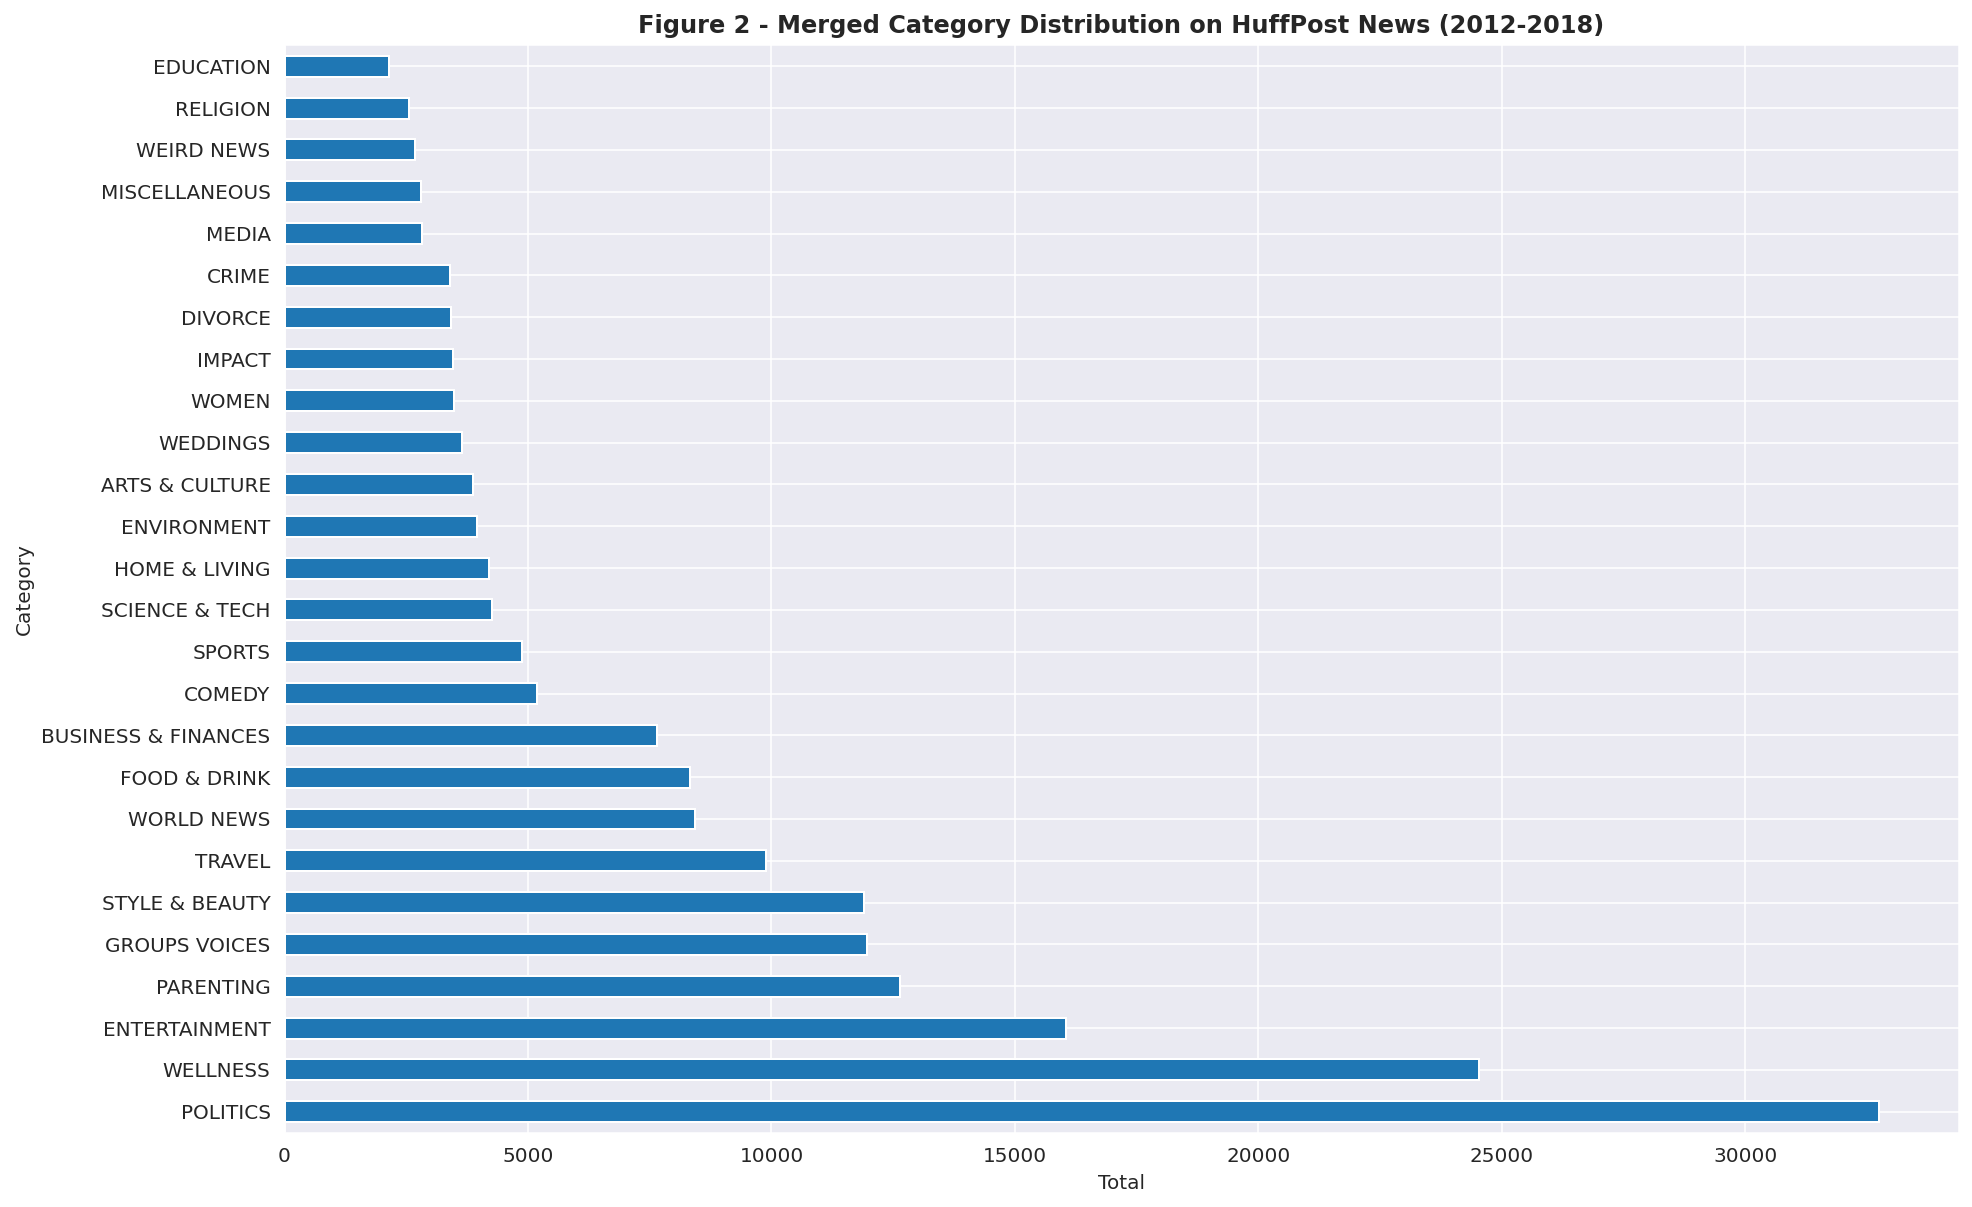

In [8]:
data['category'].value_counts().plot(kind='barh', figsize=(15,10))
plt.xlabel("Total")
plt.ylabel("Category")
plt.title("Figure 2 - Merged Category Distribution on HuffPost News (2012-2018)",
          fontweight="bold", size=12);

And now the distribution seems a little better in the categories presents in a few samples.<br>
Continuing the exploration, time to check how is the content on the `headline` feature. The Figure 3 shows the Average Word Length of the Headlines for each category.

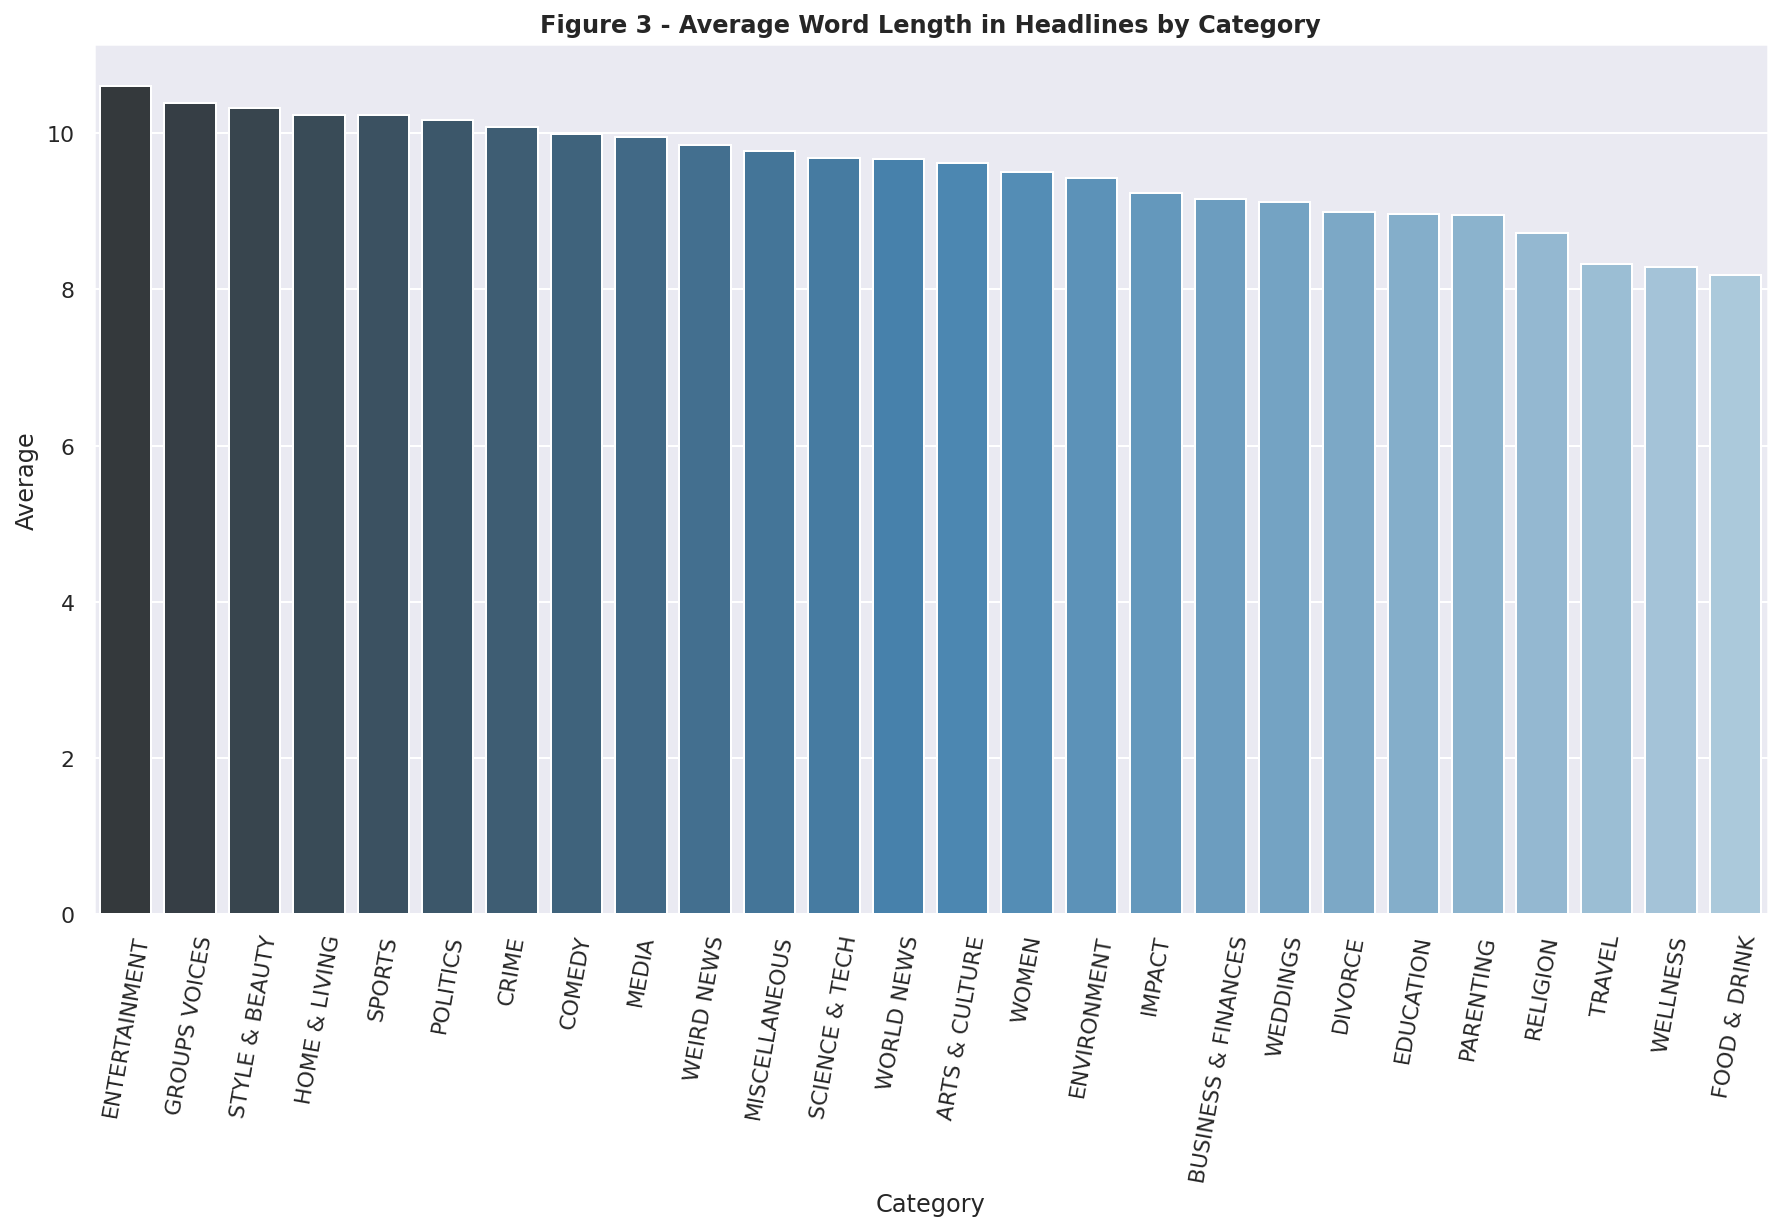

In [9]:
categories = data["category"].unique()
aux = []
j = 0
for i in categories:
    df_aux = data[data["category"] == i]
    aux.append(np.mean(df_aux['headline'].apply(lambda x : len(x.split()))))
    j = j+1

df_aux = pd.DataFrame({
    "Category" : categories,
    "Average": aux
}
)

df_aux = df_aux.sort_values(['Average'], ascending=False).reset_index(drop=True)

sns.set(rc={'figure.figsize':(15,8)})

ax = sns.barplot(x="Category", y="Average", data=df_aux, palette="Blues_d")
plt.title("Figure 3 - Average Word Length in Headlines by Category",
          fontweight="bold", size=12)
plt.xticks(rotation=80);

There's a little difference in the average for each category, about two points, making each to similar in length, but how about `short_description`?<br>
The Figure 4 shows the results for this feature.

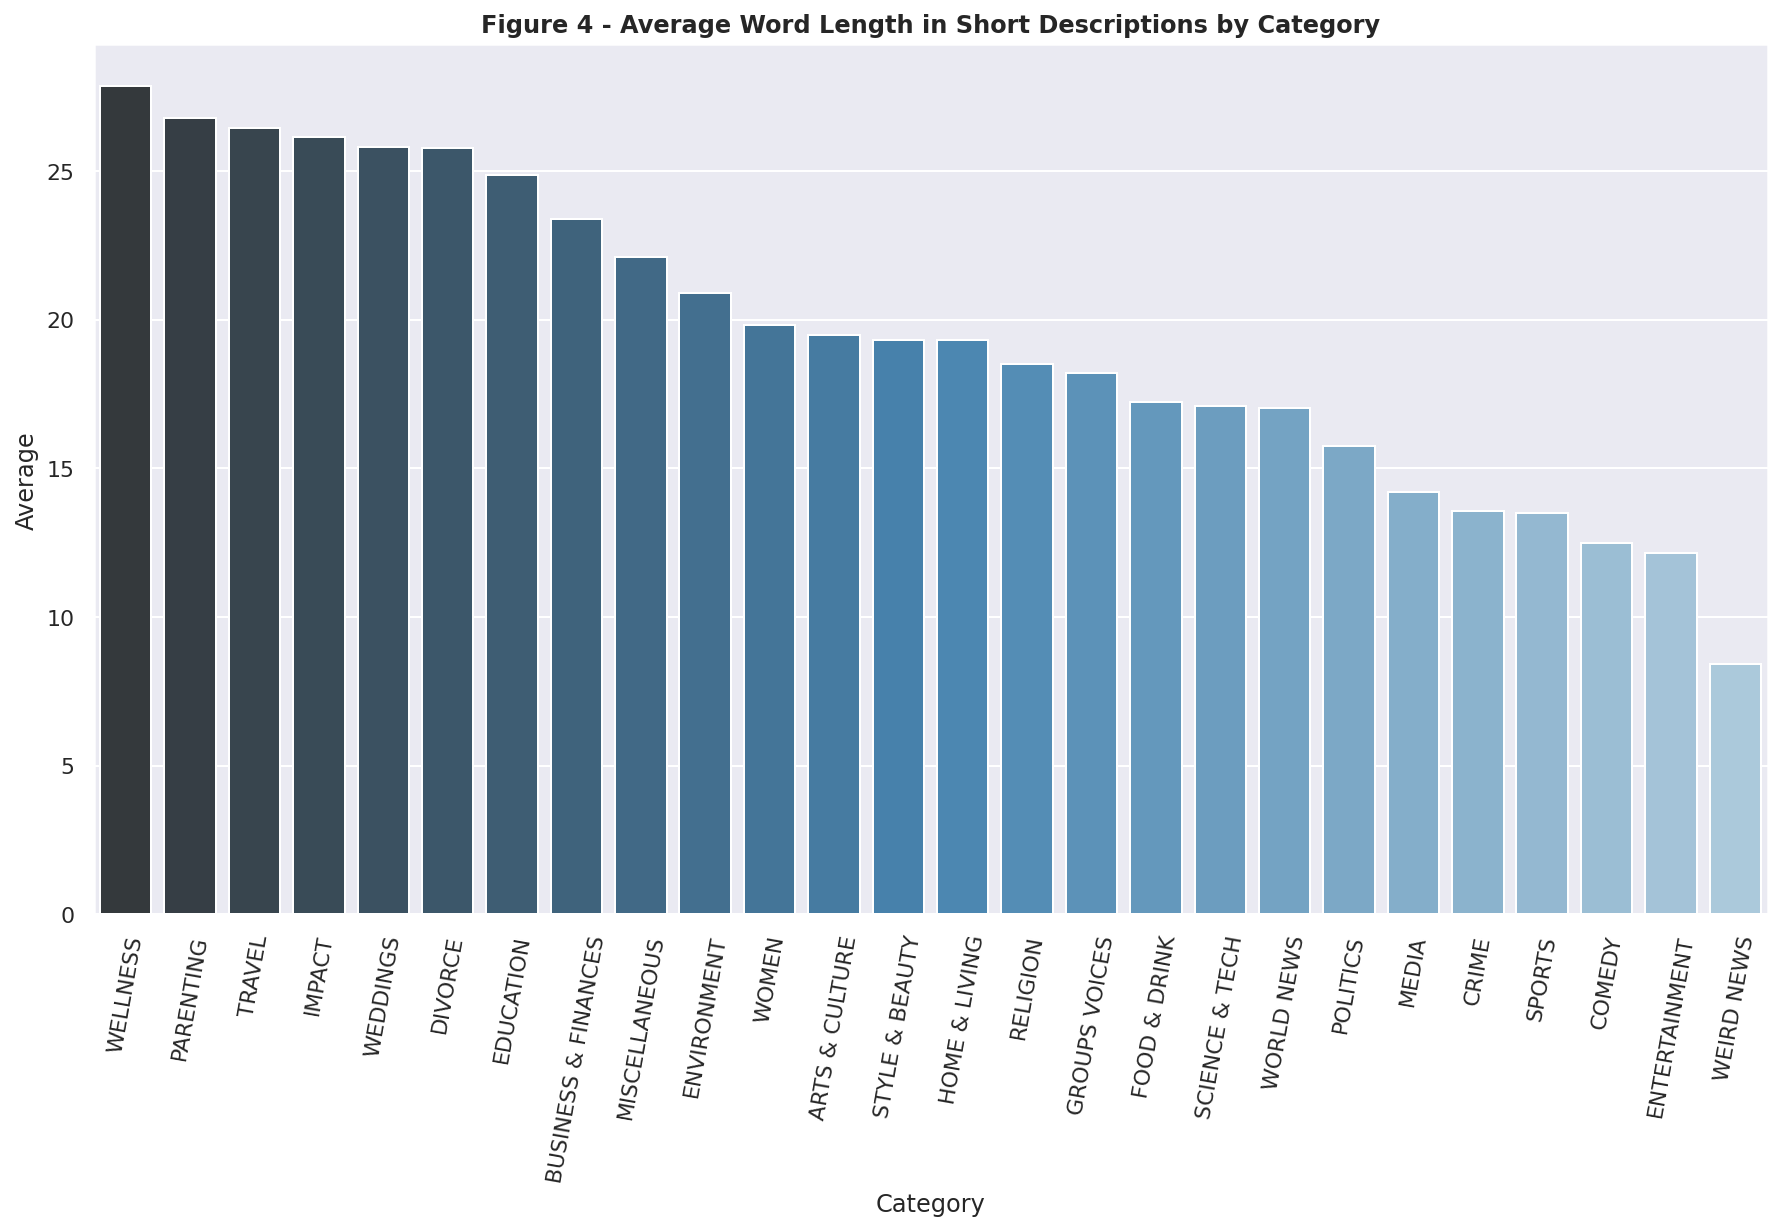

In [10]:
categories = data["category"].unique()
aux = []
j = 0
for i in categories:
    df_aux = data[data["category"] == i]
    aux.append(np.mean(df_aux['short_description'].apply(lambda x : len(x.split()))))
    j = j+1

df_aux = pd.DataFrame({
    "Category" : categories,
    "Average": aux
}
)

df_aux = df_aux.sort_values(['Average'], ascending=False).reset_index(drop=True)

sns.set(rc={'figure.figsize':(15,8)})

ax = sns.barplot(x="Category", y="Average", data=df_aux, palette="Blues_d")
plt.title("Figure 4 - Average Word Length in Short Descriptions by Category",
          fontweight="bold", size=12)
plt.xticks(rotation=80);

For the `short_description` the differences are big! Maybe it will helpful to use as input on the classification model.<br>
Let's see how many the news were posted through the years on the Figure 5.

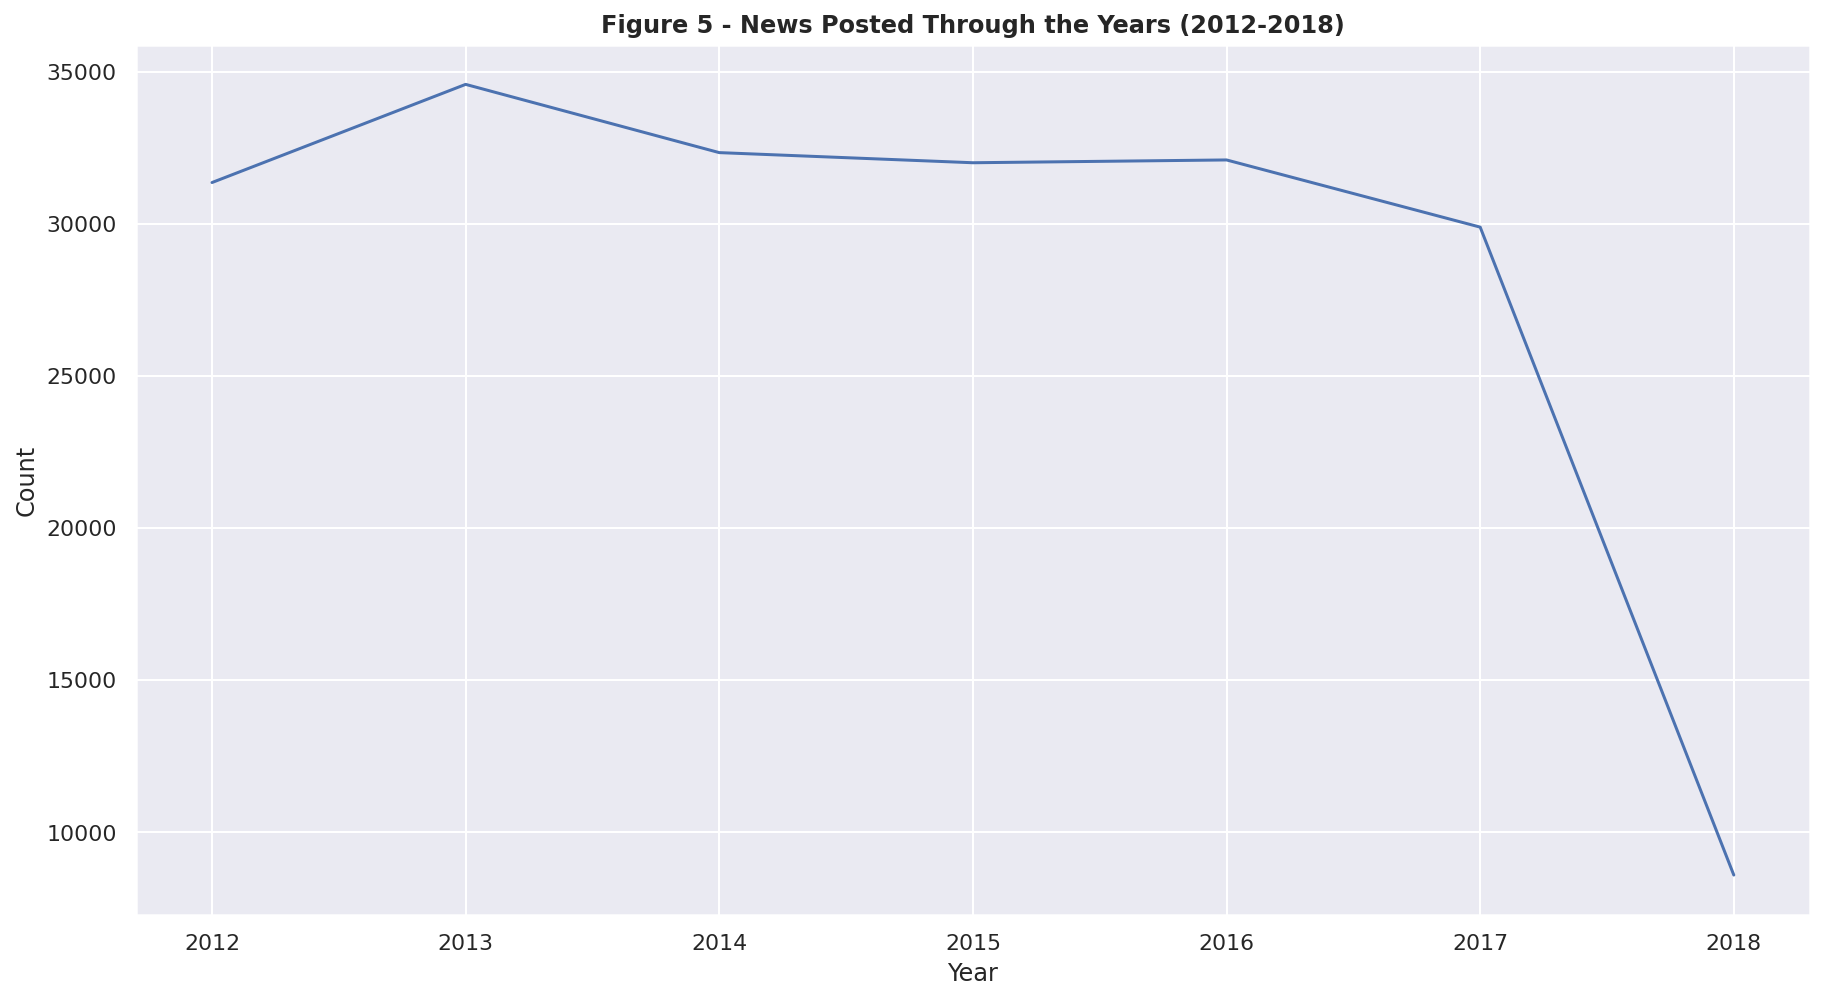

In [11]:
data["year"] = data["date"].dt.year
df_aux = data['year'].value_counts()
df_aux = pd.DataFrame({'Year': df_aux.index,
                    'Count': df_aux.values})
df_aux = df_aux.sort_values(['Count'], ascending=False).reset_index(drop=True)
ax = sns.lineplot(x="Year", y="Count", data=df_aux)
plt.title("Figure 5 - News Posted Through the Years (2012-2018)",
          fontweight="bold", size=12);

The Figure 5 shows a peak on the amount of posts on the year of 2013 and the lowest amount on 2018, but why?<br>
The Dataset was published in 2018, maybe the not get the news for the whole year like the pasts, then the lowest point is 2017 for the analysis.<br>
And what content was posted in 2013 and 2017? The Figure 6 shows the distributuion.

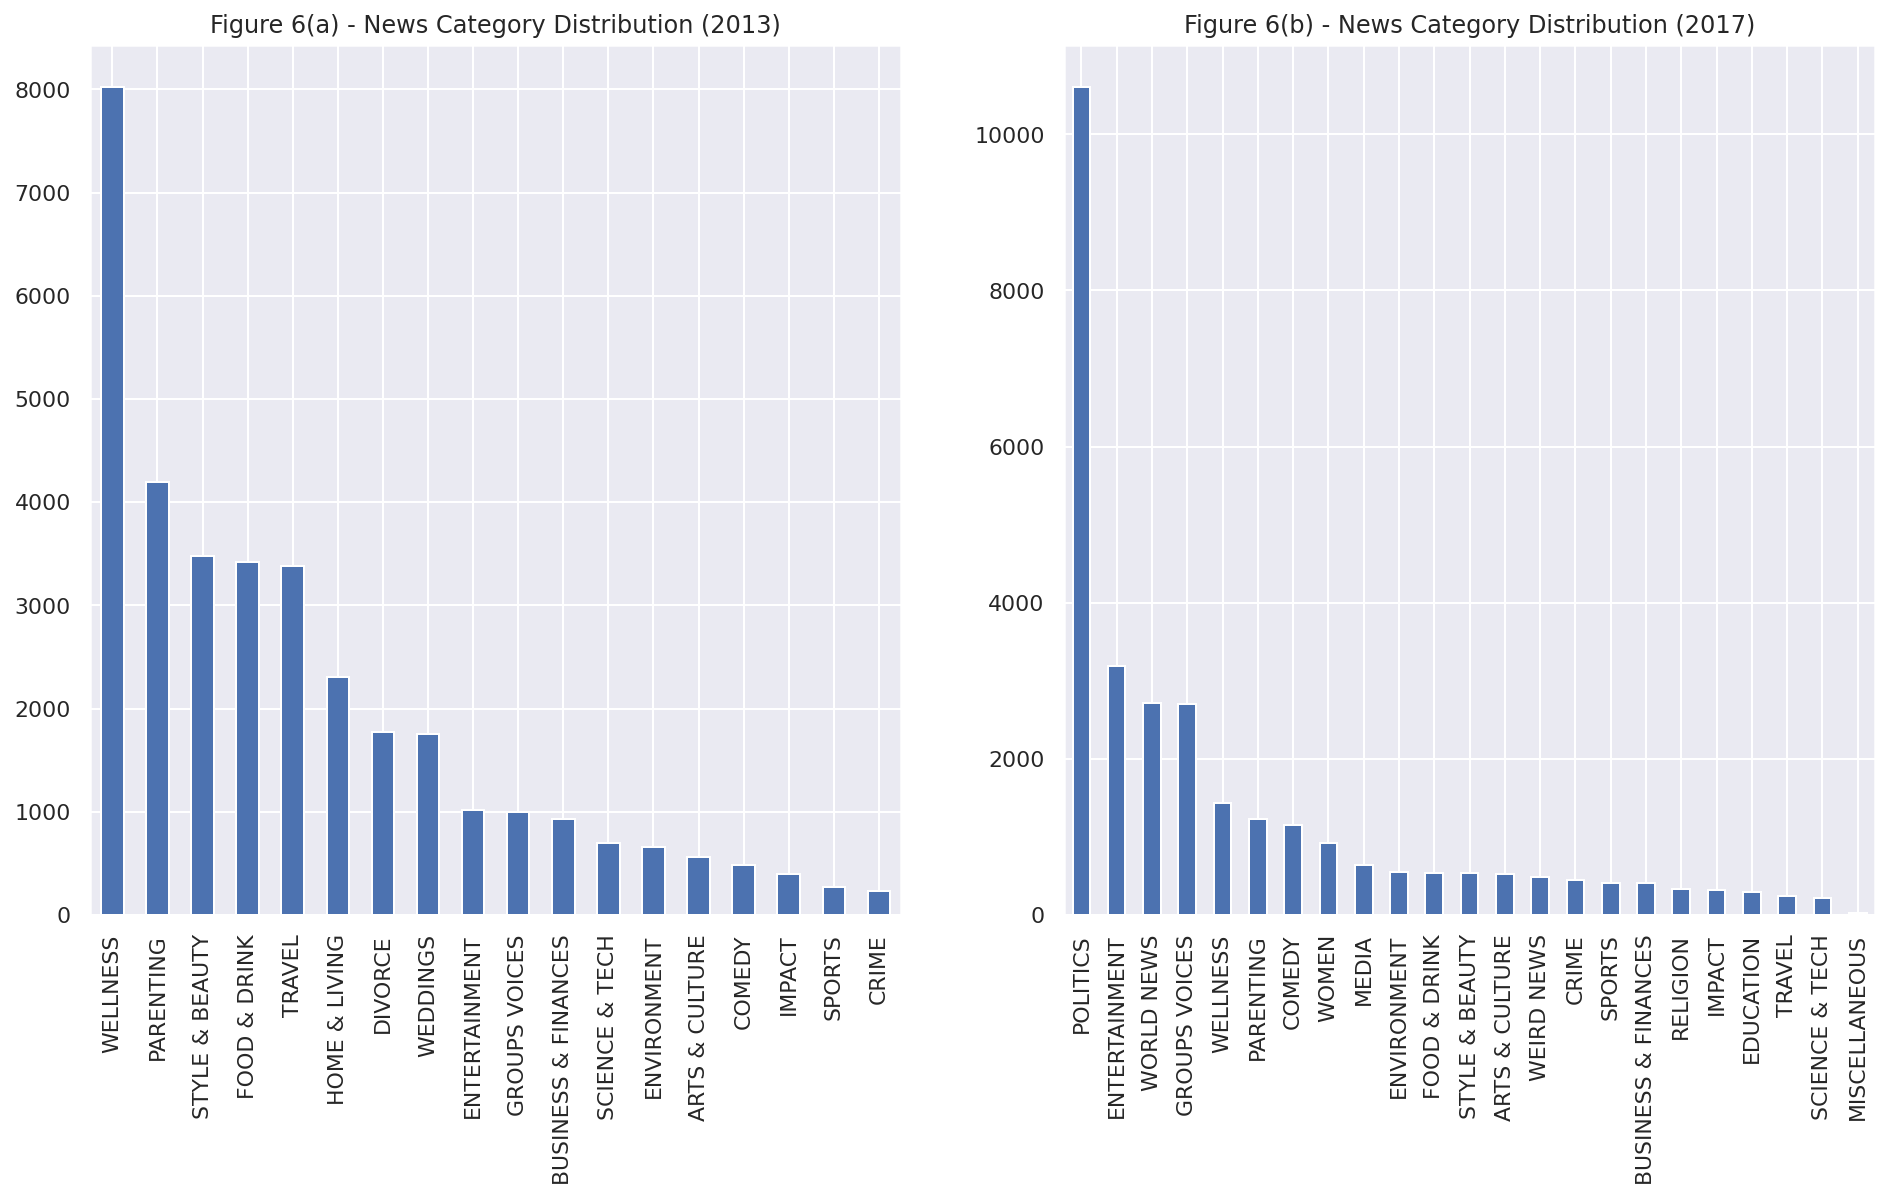

In [12]:
df_aux_a = data[data["year"] == 2013]
df_aux_b = data[data["year"] == 2017]

fig, axes = plt.subplots(nrows=1, ncols=2)
df_aux_a['category'].value_counts().sort_values(ascending=False).plot(kind='bar', ax=axes[0], figsize=(166,8),
                                                                     title="Figure 6(a) - News Category Distribution (2013)")
df_aux_b['category'].value_counts().sort_values(ascending=False).plot(kind='bar', ax=axes[1], figsize=(16,8), 
                                                                     title="Figure 6(b) - News Category Distribution (2017)");

It's curious to note on the figure 6 how HuffPost changed its content in four yers, from many posts about wellness to 2013 from much more posts about politcs in 2017.<br>
Let's see the wordclouds for these years on the Figures 7 and 8.

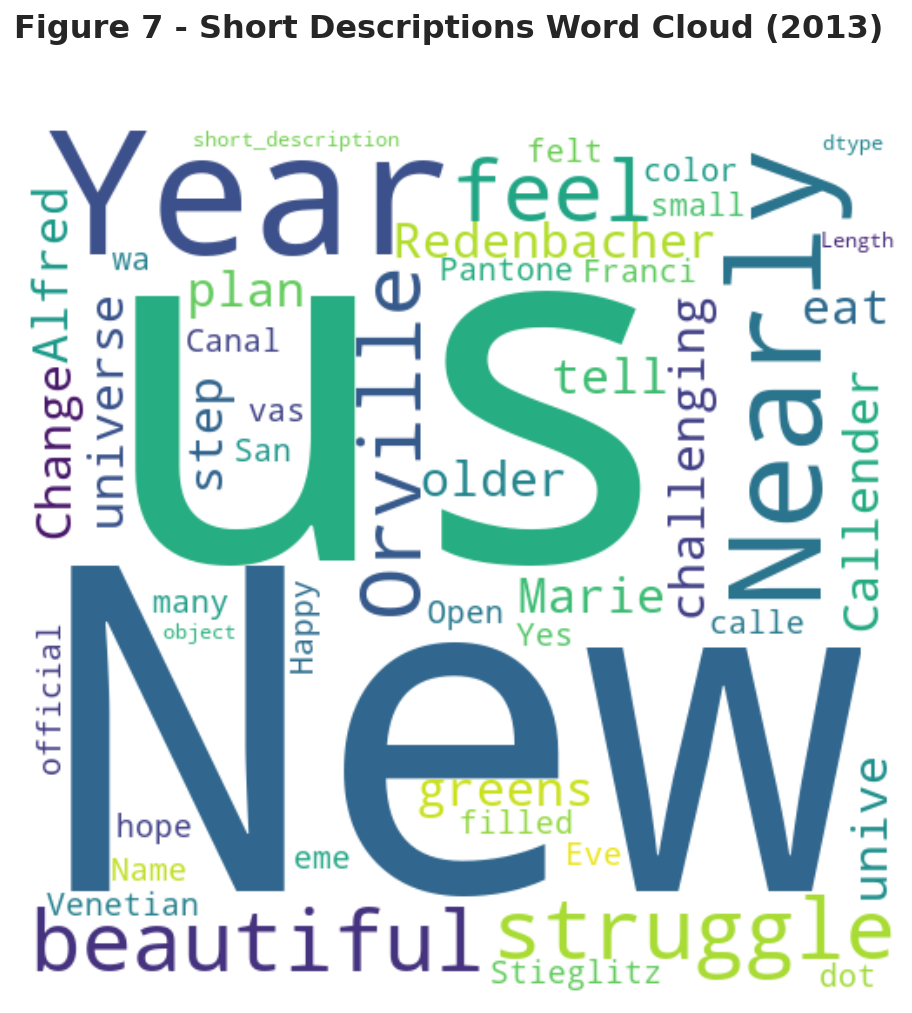

In [13]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      width=500,
                      height=500
)

wordcloud.generate(str(data.query('year == 2013')['short_description']))
plt.rcParams['figure.figsize'] = (8,8)
plt.axis('off')
plt.suptitle('Figure 7 - Short Descriptions Word Cloud (2013)', fontsize=16, fontweight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

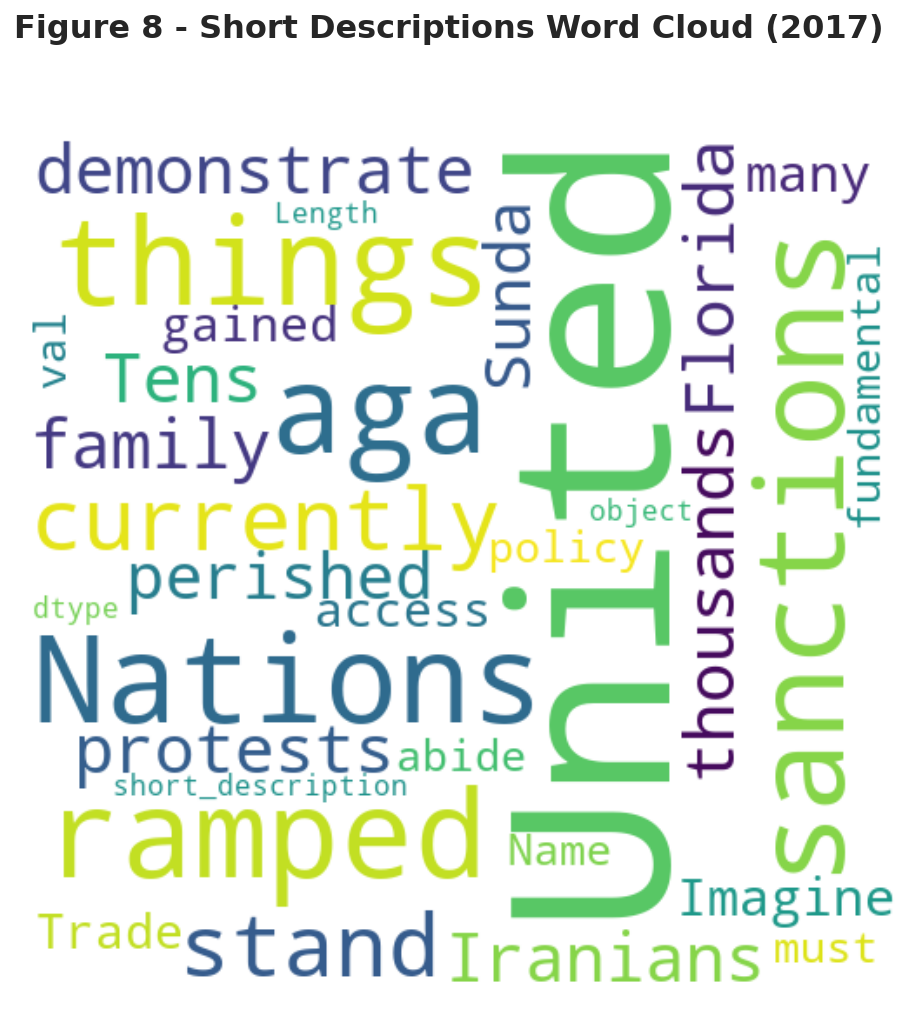

In [14]:
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      width=500,
                      height=500
)

wordcloud.generate(str(data.query('year == 2017')['short_description']))
plt.rcParams['figure.figsize'] = (8,8)
plt.axis('off')
plt.suptitle('Figure 8 - Short Descriptions Word Cloud (2017)', fontsize=16, fontweight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

On the Figure 7, can be seen positive words like "beautiful", related to wellness, while on the Figure 8 can be seen words like "Nations", "Sanctions" and "protests", related to Politcs.<br>
<br>
This concludes the EDA.

<a id='cc'></a>
<div class="h2">Category Classification</div>
<br>
On this section is made the prediction of the News Categories.<br>
The DistilBERT model is trained with FP16, just changing to Floating Point 32 (FP32) when needed. This [Kernel](https://www.kaggle.com/kashnitsky/distillbert-catalyst-amazon-product-reviews) is a great guide on how to work with it.<br>
On the Table 2 is shown the model setup

In [15]:
aux = pd.DataFrame(
    {
        "Setting": ["Model Name", "Number of Epochs", "Batch Size",
                   "Max Sequence Length", "Learning Rate", "Accumulation Steps",
                   "Random Seed"],
        "Value": ["distilbert-base-uncased", 3, 80, 256, 5e-5, 4, 42]
    }
)

display(HTML('<span style="font-weight:bold">' + 'Table 2 - Model Setup'\
             + '</span>'),aux) 

,Setting,Value
0,Model Name,distilbert-base-uncased
1,Number of Epochs,3
2,Batch Size,80
3,Max Sequence Length,256
4,Learning Rate,5e-05
5,Accumulation Steps,4
6,Random Seed,42


In [16]:
MODEL_NAME = "distilbert-base-uncased"
LOG_DIR = "./news-classification"    
NUM_EPOCHS = 3                         
BATCH_SIZE = 80                        
MAX_SEQ_LENGTH = 256                   
LEARN_RATE = 5e-5                      
ACCUM_STEPS = 4                        
SEED = 42                              
FP16_PARAMS = None

Kaggle Kernels doesn't has Apex installed by default. The following two blocks of code have the scripts to install it.

In [17]:
%%writefile setup.sh
git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
rm -rf ./apex

Writing setup.sh


In [18]:
%%capture
!sh setup.sh
FP16_PARAMS = dict(opt_level="O1") 

In [19]:
# Use it if you need just to test if the model is working
# with a few samples
#data = data.head(1000)

The Dataset is split in 70% for the Train set and 30% for the Validation set.<br>
A Test set with separeted labels is created from 10% of the Validation set.

In [20]:
text = pd.DataFrame({
    "text" : data.headline+" "+data.short_description,
    "label" : data.category  
})

train, val = train_test_split(
    text, test_size=0.30, random_state=SEED)

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

val, test = train_test_split(
    val, test_size=0.10, random_state=SEED)

val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

test_true = pd.DataFrame({
    "label" : test.label
})

test.drop(columns=["label"], axis=1, inplace=True)

#del data

PyTorch uses a specific input called tensors, all the dataset needs to be converted to tensors.<br>
It's needed to create a class to convert to tensors and after load every set (Train, Validation and Test).

In [21]:
class TextClassificationDataset(Dataset):

    def __init__(self,
                 texts: List[str],
                 labels: List[str] = None,
                 label_dict: Mapping[str, int] = None,
                 max_seq_length: int = 512,
                 model_name: str = 'distilbert-base-uncased'):

        self.texts = texts
        self.labels = labels
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

        if self.label_dict is None and labels is not None:
            self.label_dict = dict(zip(sorted(set(labels)),
                                       range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        logging.getLogger(
            "transformers.tokenization_utils").setLevel(logging.FATAL)

        self.sep_vid = self.tokenizer.vocab["[SEP]"]
        self.cls_vid = self.tokenizer.vocab["[CLS]"]
        self.pad_vid = self.tokenizer.vocab["[PAD]"]

    def __len__(self):

        return len(self.texts)

    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:

        x = self.texts[index]
        x_encoded = self.tokenizer.encode(
            x,
            add_special_tokens=True,
            max_length=self.max_seq_length,
            return_tensors="pt",
        ).squeeze(0)

        true_seq_length = x_encoded.size(0)
        pad_size = self.max_seq_length - true_seq_length
        pad_ids = torch.Tensor([self.pad_vid] * pad_size).long()
        x_tensor = torch.cat((x_encoded, pad_ids))

        mask = torch.ones_like(x_encoded, dtype=torch.int8)
        mask_pad = torch.zeros_like(pad_ids, dtype=torch.int8)
        mask = torch.cat((mask, mask_pad))

        output_dict = {
            "features": x_tensor,
            'attention_mask': mask
        }

        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor(
                [self.label_dict.get(y, -1)]
            ).long().squeeze(0)
            output_dict["targets"] = y_encoded

        return output_dict

In [22]:
train_dataset = TextClassificationDataset(
    texts=train['text'].values.tolist(),
    labels=train['label'].values.tolist(),
    label_dict=None,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

valid_dataset = TextClassificationDataset(
    texts=val['text'].values.tolist(),
    labels=val['label'].values.tolist(),
    label_dict=train_dataset.label_dict,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

test_dataset = TextClassificationDataset(
    texts=test['text'].values.tolist(),
    labels=None,
    label_dict=None,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

And define the number of classes of the output feature based on the train set.

In [23]:
NUM_CLASSES = len(train_dataset.label_dict)

When working with PyTorch, the sets need to be loaded in dictionaries.

In [24]:
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=False)    
}

A class defines the model with its forward pass.

In [25]:
class DistilBertForSequenceClassification(nn.Module):

    def __init__(self, pretrained_model_name: str, num_classes: int = None):

        super().__init__()

        config = AutoConfig.from_pretrained(
            pretrained_model_name, num_labels=num_classes)

        self.distilbert = AutoModel.from_pretrained(pretrained_model_name,
                                                    config=config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

    def forward(self, features, attention_mask=None, head_mask=None):

        assert attention_mask is not None, "attention mask is none"
        distilbert_output = self.distilbert(input_ids=features,
                                            attention_mask=attention_mask,
                                            head_mask=head_mask)

        hidden_state = distilbert_output[0]  
        pooled_output = hidden_state[:, 0] 
        pooled_output = self.pre_classifier(pooled_output)  
        pooled_output = nn.ReLU()(pooled_output)  
        pooled_output = self.dropout(pooled_output)  
        logits = self.classifier(pooled_output)  

        return logits

Finally, the load the model with the criterion, optimizer and learning rate scheduler.<br>
And setting the GPU devices to use and Random Seed.

In [26]:
model = DistilBertForSequenceClassification(pretrained_model_name=MODEL_NAME,
                                            num_classes=NUM_CLASSES)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [27]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"   
set_global_seed(SEED)                       
prepare_cudnn(deterministic=True)           

The model training starts now with Catalyst doing a good amount of work.

In [28]:
%%time 
runner = SupervisedRunner(
    input_key=(
        "features",
        "attention_mask"
    )
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=train_val_loaders,
    callbacks=[
        AccuracyCallback(num_classes=NUM_CLASSES),
#       F1ScoreCallback(activation='Softmax'), # Tried it, but got an error on tensor shape
        OptimizerCallback(accumulation_steps=ACCUM_STEPS)
    ],
    fp16=FP16_PARAMS,
    logdir=LOG_DIR,
    num_epochs=NUM_EPOCHS,
    verbose=True
)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
1/3 * Epoch (train):  63% 1103/1758 [19:17<11:27,  1.05s/it, _timer/_fps=76.496, _timer/batch_time=1.046, _timer/data_time=1.030, _timer/model_time=0.016, accuracy01=0.613, accuracy03=0.800, accuracy05=0.925, loss=1.268]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
1/3 * Epoch (

To finish it, let's make an inference on Test Set to predict the results later.

In [29]:
test_loaders = {
    "test": DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=False) 
}

runner.infer(
    model=model,
    loaders=test_loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{LOG_DIR}/checkpoints/best.pth"
        ),
        InferCallback(),
    ],   
    verbose=True
)

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
=> loading checkpoint ./news-classification/checkpoints/best.pth
loaded checkpoint ./news-classification/checkpoints/best.pth (global epoch 2, epoch 2, stage train)
1/1 * Epoch (test): 100% 76/76 [00:32<00:00,  2.33it/s]


<a id='re'></a>
<div class="h2">Results</div>
<br>
With the Inference made on the Test Set, let's predict the probabilities of classes for each samples and get class with the high probability and save as the prediction.<br>
The Results for the accuracy, precision and F1 Score for the Test Set are given followed by the Confusion Matrix on The Figure 9.

Test Accuracy: 0.7608695652173914
Test Precision: 0.7544679755279048
Test F1 Score: 0.7541500996169954


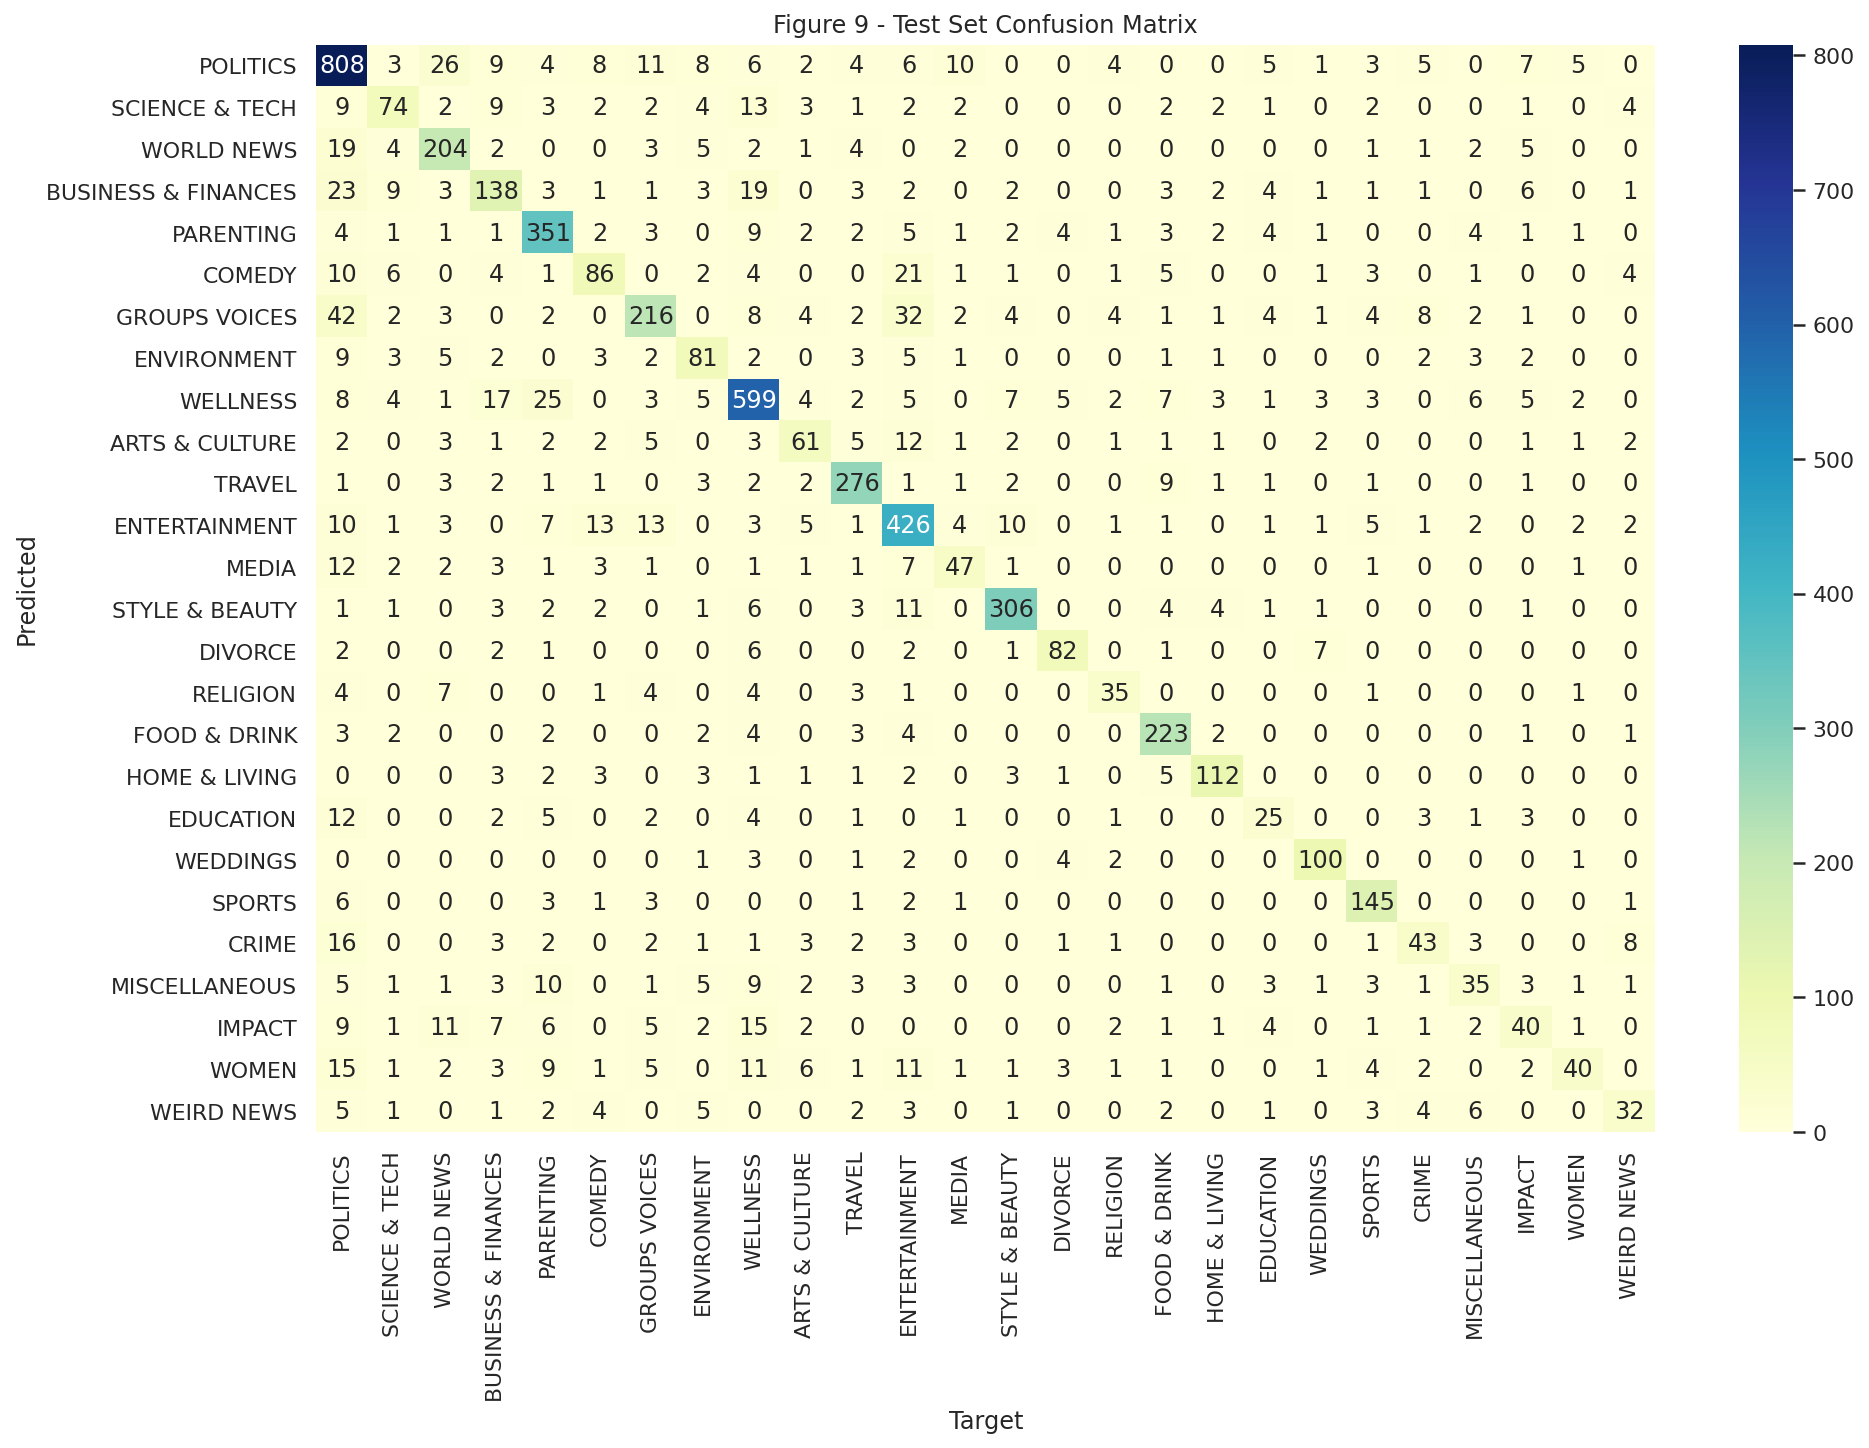

In [30]:
predicted_probs = runner.state.callbacks[0].predictions['logits']
test_pred = pd.DataFrame(
    {
        "label": predicted_probs.argmax(axis=1)
    }
)
test_pred["label"] = test_pred["label"].map({v:k for k, v in train_dataset.label_dict.items()})

unique_label = train["label"].unique()
cmtx = pd.DataFrame(
    confusion_matrix(test_true, test_pred, labels=unique_label), 
    index=['{:}'.format(x) for x in unique_label], 
    columns=['{:}'.format(x) for x in unique_label]
)

plt.figure(figsize=(15, 10))
ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
ax.set_ylabel('Predicted')
ax.set_xlabel('Target');
ax.set_title("Figure 9 - Test Set Confusion Matrix", size=12)

acc = accuracy_score(test_true, test_pred)
prec = precision_score(test_true, test_pred, average="weighted")
f1 = f1_score(test_true, test_pred, average="weighted")
print(f"Test Accuracy: {acc}")
print(f"Test Precision: {prec}")
print(f"Test F1 Score: {f1}");

<a id='end'></a>
<div class="h2">Conclusion</div>
<br>
On the EDA, was shwon that HuffPost changed a lot its content from the year, from a website with many posts about wellness to a site with opinions and news about politics.<br> 
As seen by the results, the three metrics got a good score (above 0.7) and the matrix confusion revealed a few samples with wrong classification.<br> DistilBERT showed how can it be powerful for NLP.<br>